![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
pip install livelossplot

In [96]:
# Importación librerías
import pandas as pd
import os
import numpy as np
import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Redes neuronales
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [90]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

## Procesamiento de datos

In [91]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [92]:
#Importando diccionario de embeddings
#Se descarga de https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#Sugerido por tutorial de keras: https://keras.io/examples/nlp/pretrained_word_embeddings/
embedding_dim = 300 #Se define la dimensión de los embeddings usados. Se eleigen entre 50, 100, 200 y 300
path_to_glove_file = r'/content/glove.6B.'+str(embedding_dim)+'d.txt' #Ruta donde se descomprimen los txt
embeddings_index = {} #Se guarda el diccionario de los embeddings

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [100]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

def procesaTexto(text,lematize =True, stemming = False):
    """
    Preprocesamiento de textos para utilizar en el modelo.

    Parametros:

    text(str): la cadena de texto a la que se le va a aplicar el procesamiento.
    lematize
    """
    text = text.lower() #Pasar el texto a minúsculas
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Eliminar palabras cortas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    #Exclusión de stopwords
    english_stopwords = nltk.corpus.stopwords.words('english')
    words = text.split()
    words = [word for word in words if word.lower() not in english_stopwords]
    #Stemming
    if stemming == True:
        stemmer = PortStemmer()
        words = [stemmer.stem(word) for word in words]  # Aplicar stemming
    #Lematización
    if lematize ==True:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

#Función que obtiene los embedings de las palabras
def generaEmbedding(text):
    words = text.split()
    embeddings = []
    for word in words:
        if word in embeddings_index: #Se debe contar con el indice de embeddings
            embeddings.append(embeddings_index[word])
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)  # Si la palabra no existe se rellena del tamaño de la longitud de los embeddings
    return np.mean(embeddings, axis=0)

In [101]:
# Procesamiento
#Pre procesamiento del texto

#Para datos de entrenamiento
dataTraining['final_plot'] = dataTraining['plot'].apply(procesaTexto) #Se alimpia limpieza de texto
X_embeddings = np.array([generaEmbedding(text) for text in dataTraining['final_plot']]) #Se consiguen los embeddings
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_genres, test_size=0.2, random_state=42) #Se separan los datos

#Para datos de prueba (competencia)
dataTesting['final_plot'] = dataTesting['plot'].apply(procesaTexto) #Se alimpia limpieza de texto
X_embeddingsTest = np.array([generaEmbedding(text) for text in dataTesting['final_plot']]) #Se consiguen los embeddings

## Modelamiento

### Doble capa + Dropout

In [160]:
# Definición del modelo
K.clear_session()
model_1 = Sequential()
model_1.add(Dense(100, activation='relu', input_shape=(X_embeddings.shape[1],)))
model_1.add(Dense(400, activation = 'relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(len(le.classes_), activation='softmax'))

# Compilación del modelo
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 400)               40400     
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                9624      
                                                                 
Total params: 80124 (312.98 KB)
Trainable params: 80124 (312.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


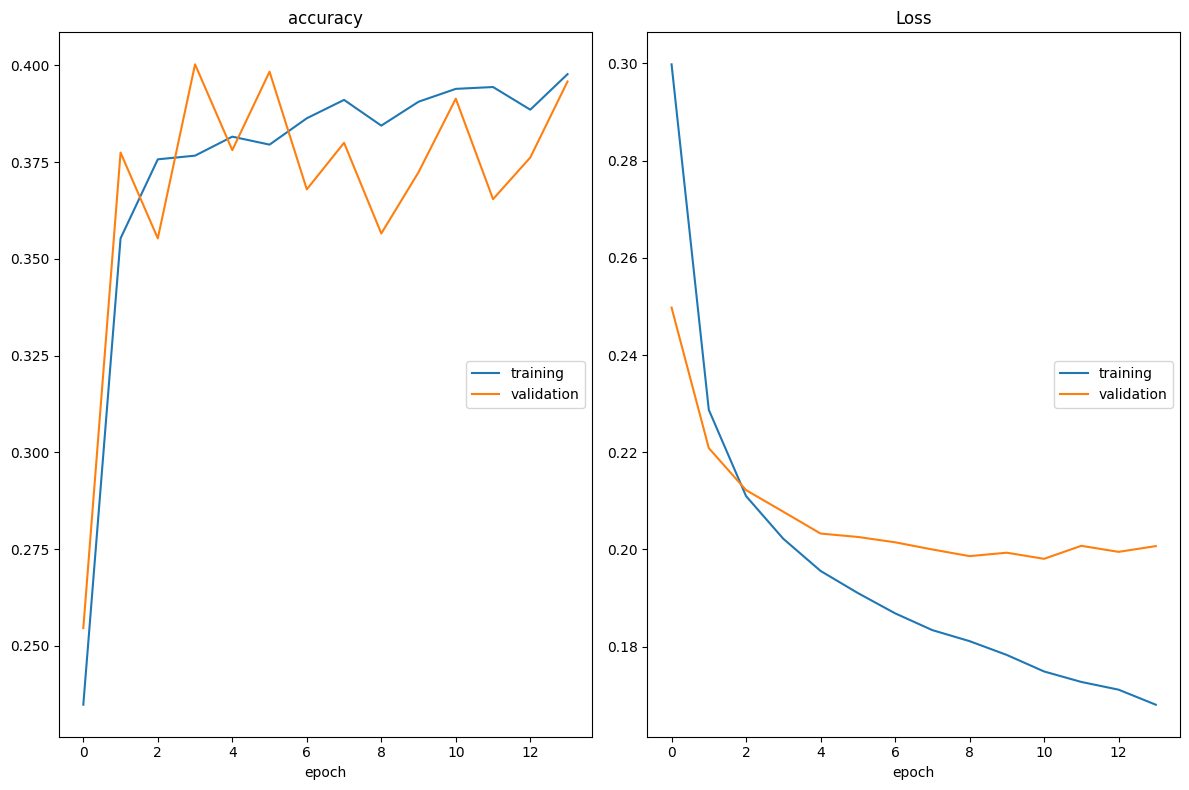

accuracy
	training         	 (min:    0.235, max:    0.398, cur:    0.398)
	validation       	 (min:    0.255, max:    0.400, cur:    0.396)
Loss
	training         	 (min:    0.168, max:    0.300, cur:    0.168)
	validation       	 (min:    0.198, max:    0.250, cur:    0.201)
198/198 - 2s - loss: 0.1681 - accuracy: 0.3977 - val_loss: 0.2007 - val_accuracy: 0.3958 - 2s/epoch - 11ms/step
50/50 [==============================] - 0s 2ms/step


0.8813546519705998

In [161]:
# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_1.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=[
    early_stopping,
    PlotLossesKeras()])
# Predicción del modelo de clasificación
y_pred_genres_p1 = model_1.predict(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test, y_pred_genres_p1, average='macro')

In [134]:
# Nombres de las columnas
column_names = ["Dense1", "Dense2", "Dropout", "Dense3", "Accuracy"]

# Crear el DataFrame
df = pd.DataFrame(resultados, columns=column_names)
df_sorted = df.sort_values(by="Accuracy", ascending=False)
df_sorted.head()

,Dense1,Dense2,Dropout,Dense3,Accuracy
53,400,100,0.2,100,0.878709
27,100,200,0.2,400,0.878585
11,50,200,0.2,400,0.877977
41,200,200,0.2,100,0.877108
49,400,50,0.2,100,0.877084


## Testeo del modelo

In [158]:
# transformación variables predictoras X del conjunto de test

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = model_1.predict(X_embeddingsTest)

106/106 [==============================] - 0s 2ms/step


In [159]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.004779,0.035538,0.002736,0.009606,0.574404,0.038164,0.002241,0.610965,0.007448,0.032771,...,0.019711,0.036448,0.000086,0.543353,0.001870,0.006865,0.001133,0.078054,0.005407,0.021481
4,0.118476,0.001317,0.000067,0.074117,0.125833,0.720522,0.020532,0.888655,0.000377,0.000028,...,0.001122,0.000523,0.000017,0.013159,0.000033,0.001826,0.006874,0.104777,0.015352,0.006677
5,0.043903,0.004038,0.000304,0.115819,0.099581,0.774090,0.066112,0.799999,0.001548,0.006504,...,0.000990,0.276426,0.004345,0.056754,0.007582,0.002622,0.001820,0.582030,0.006266,0.001095
6,0.256974,0.063717,0.001298,0.026883,0.079159,0.078219,0.007139,0.816387,0.002850,0.018016,...,0.001153,0.054351,0.000809,0.107278,0.214409,0.001372,0.002463,0.609906,0.061217,0.003079
7,0.014896,0.005545,0.003973,0.023710,0.152910,0.162659,0.009246,0.454391,0.009905,0.117362,...,0.006301,0.334062,0.002297,0.079390,0.152722,0.008504,0.000112,0.543589,0.001628,0.000587
